In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import recall_score, classification_report,accuracy_score,confusion_matrix,average_precision_score
from scipy.stats import randint, uniform
import os
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
PROJECT_ROOT = Path.cwd().parent
os.chdir(PROJECT_ROOT)

In [3]:
X = pd.read_csv("data/fe/X_train_fe.csv")
y = pd.read_csv("data/fe/y_train.csv").squeeze()

In [4]:
cat_cols = [c for c in ["Sex", "Embarked", "Title"] if c in X.columns]
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [5]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [6]:
param_dist = {
    "n_estimators": randint(200, 1200),
    "max_depth": randint(3, 8),
    "learning_rate": uniform(0.01, 0.19),
    "subsample": uniform(0.6, 0.4),
    "colsample_bytree": uniform(0.6, 0.4),
    "reg_alpha": uniform(0.0, 1.0),
    "reg_lambda": uniform(1.0, 5.0),
}


In [7]:
search = RandomizedSearchCV(
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="auc",
        random_state=42,
        n_jobs=-1
    ),
    param_distributions=param_dist,
    n_iter=40,
    scoring="recall",
    cv=cv,
    verbose=1,
    n_jobs=-1
)

search.fit(X, y)


Fitting 5 folds for each of 40 candidates, totalling 200 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': <scipy.stats....001BAC34127E0>, 'learning_rate': <scipy.stats....001BAC3411850>, 'max_depth': <scipy.stats....001BAC3411970>, 'n_estimators': <scipy.stats....001BA8E841A60>, ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'recall'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guid

In [8]:
print("Best CV average_precision:", search.best_score_)
print("Best params:", search.best_params_)

Best CV average_precision: 0.7472053872053873
Best params: {'colsample_bytree': np.float64(0.7355344763876102), 'learning_rate': np.float64(0.049413559350156816), 'max_depth': 3, 'n_estimators': 863, 'reg_alpha': np.float64(0.40730290713235395), 'reg_lambda': np.float64(1.611311333276205), 'subsample': np.float64(0.871115923165853)}


In [9]:
X_test = pd.read_csv("data/fe/X_test_fe.csv")
y_test = pd.read_csv("data/fe/y_test.csv").squeeze()

In [10]:
X_test = pd.get_dummies(
    X_test,
    columns = cat_cols,
    drop_first =True
)
X, X_test = X.align(X_test, axis=1, fill_value=0)

In [11]:
final_tree = XGBClassifier(
    **search.best_params_,
    random_state=42
)
final_tree.fit(X, y)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,np.float64(0.7355344763876102)
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.data

In [12]:
y_pred = final_tree.predict(X_test)

In [13]:
accuracy_score(y_test, y_pred)

0.7988826815642458

In [14]:
recall_score(y_test, y_pred)

0.6666666666666666

In [15]:
confusion_matrix(y_test, y_pred)

array([[97, 13],
       [23, 46]])

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       110
           1       0.78      0.67      0.72        69

    accuracy                           0.80       179
   macro avg       0.79      0.77      0.78       179
weighted avg       0.80      0.80      0.80       179



In [17]:
accuracy = accuracy_score(y_test, y_pred)
error_rate = 1 -accuracy
print(f'Точность R^2: {accuracy}')
print(f'Доля ошибочных классификаций: {error_rate}')

Точность R^2: 0.7988826815642458
Доля ошибочных классификаций: 0.2011173184357542


Text(50.722222222222214, 0.5, 'True Label')

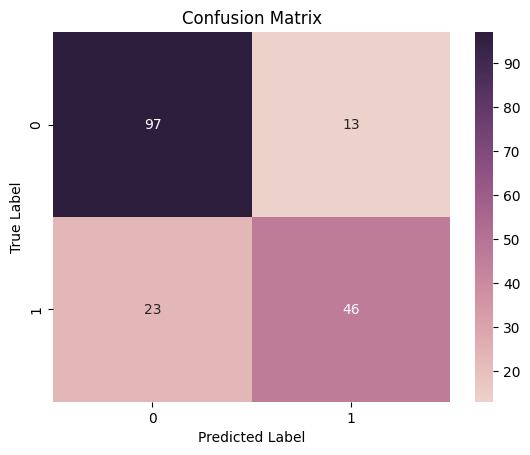

In [18]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, cmap=sns.cubehelix_palette(as_cmap=True))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [19]:
average_precision_score(y_test, y_pred)

0.6482656314111669